# Noise Map

In [18]:
%matplotlib inline
import os
from pathlib import Path
import sys
sys.path.append(str(Path(os.getcwd()).parent.parent))
from src.utils import ElevationHandler, transform_coordinates, Line, calcAgr, import_point_source_data, calc_diffraction_path, atmospheric_absorption, A_weighting, calc_extent, ElevationHandlerTest
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib.colors import LogNorm
from pyproj import Geod

In [19]:
# map_boundaries = [11.9, 12.1, 54.9, 55.1]
dist = 2000
point_source_data = import_point_source_data("Prøvestenen1.json")
map_boundaries = calc_extent(point_source_data, dist)
# map_boundaries = [0, 210, 0, 210]
map_shape = [100, 100]
elevation_handler = ElevationHandler(map_boundaries, map_shape)
# elevation_handler = ElevationHandlerTest(map_boundaries, map_shape)

def solve_noise_map(elevation_handler, point_source_data):

    LDW = np.zeros_like(elevation_handler.map_array) # init res

    for i, point_source in point_source_data.iterrows(): # iterate over each point source

        Lf = np.zeros_like(elevation_handler.map_array) # init res

        dp, d, dss, dsr, e = calc_diffraction_path(elevation_handler, point_source)
        
        z = (dss + e + dsr) - d

        Kmet = np.ones_like(z) # init Kmet
        mask_direct = z > 0 # mask direct path (True for diffraction)
        mask_multiple = e > 0 # mask multiple diffractions (True for multiple diffractions)
        Kmet[mask_direct] = np.exp(-(1/2000) * np.sqrt(dss[mask_direct] * dsr[mask_direct] * d[mask_direct] / (2 * z[mask_direct]))) # Calculate Kmet only where the mask is True

        hs = point_source.h
        hr = 0

        for f, LW in point_source.octave_band.items(): # iterate over each octave-band sound power level
            f = int(f)
            tempeature = 20 # [deg C]
            c = 331.5 * np.sqrt(1 + tempeature / 273.15) # speed of sound in air [m/s]
            wavelength = c/f # [m]
            C2 = 20

            C3 = np.ones_like(z) # init Kmet
            C3[mask_multiple] = (1 + (5*wavelength/e[mask_multiple])**2) / (1/3 + (5*wavelength/e[mask_multiple])**2)

            Dz = np.zeros_like(z)
            Dz[mask_direct] = 10 * np.log10(3 + (C2 / wavelength) * C3[mask_direct] * z[mask_direct] * Kmet[mask_direct])

            G = 0.5 # ground factor
            Agr = calcAgr(f, dp, G, hs, hr)

            alpha = atmospheric_absorption(f, tempeature, rh=70, ps=1.01325e5)
            Aatm = alpha * d

            Adiv = 20 * np.log10(d) + 11
            Abar = np.maximum(Dz - Agr, 0)
            A = Adiv + Aatm #+ Abar + Agr
            
            Lf += 10**(0.1 * (LW - A + A_weighting(f)))
        Lf = 10 * np.log10(Lf)
        LDW += 10**(0.1 * Lf)
    LDW = 10 * np.log10(LDW)
    return LDW
LDW = solve_noise_map(elevation_handler, point_source_data)

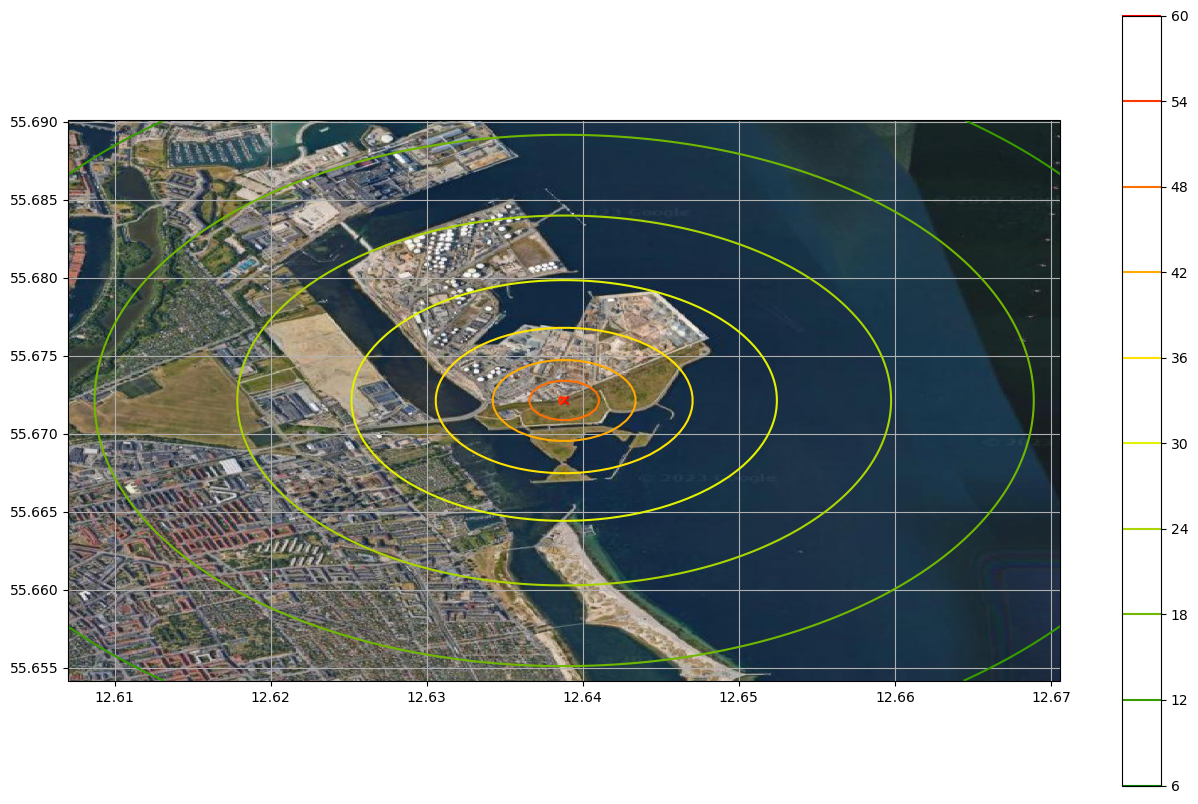

In [20]:
from cartopy.io.img_tiles import GoogleTiles
import cartopy.crs as ccrs
from matplotlib.ticker import AutoLocator
from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list('name', ['green', 'yellow', 'red'])

# levels = [35, 40, 45]
# levels = [34, 39, 44, 49, 54]
# fig, ax = plt.subplots()
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(16, 10))
cp = ax.contour(elevation_handler.long_range, elevation_handler.lat_range, LDW, alpha = 1, cmap = cmap)
ax.scatter(point_source_data.longitude, point_source_data.latitude, marker = "x", color = "red")
plt.colorbar(cp, ax = ax)

imagery = GoogleTiles(style = "satellite") # Valid styles: street, satellite, terrain, only_streets
ax.add_image(imagery, 14) # 16

ax.set_xticks([0], crs=ccrs.PlateCarree())
ax.set_yticks([0], crs=ccrs.PlateCarree())
ax.xaxis.set_major_locator(AutoLocator())
ax.yaxis.set_major_locator(AutoLocator())

plt.grid()
plt.show()